In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


%matplotlib inline


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## Utility functions

In [3]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class LayerActivations():
    features=[]
    
    def __init__(self,model):
        self.features = []
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        
        self.features.extend(output.view(output.size(0),-1).cpu().data)

    
    def remove(self):
        
        self.hook.remove()
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [4]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [5]:
train_dset = ImageFolder('C:/Users/USER/Desktop/Heo/Pytorch/chapter8/Study/20210702/data1/data_1/train/',transform=data_transform)
val_dset = ImageFolder('C:/Users/USER/Desktop/Heo/Pytorch/chapter8/Study/20210702/data1/data_1/val/',transform=data_transform)
classes=2

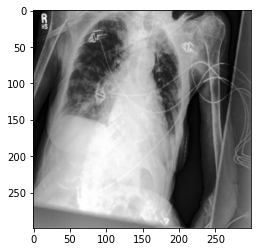

In [6]:
imshow(train_dset[155][0])

## Creating data loader for training and validation datasets

In [7]:
train_loader = DataLoader(train_dset,batch_size=16,shuffle=True,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=16,shuffle=False,num_workers=3)

## Creating Inception V3 model

In [8]:
inception = inception_v3(pretrained=True)
inception.aux_logits = False
if is_cuda:
    inception = inception.cuda()

## Extracting Convolutional features

In [13]:
# Create LayerActivations object to store the output of inception model at a particular layer.
trn_features = LayerActivations(inception.Mixed_7c)
trn_labels = []

# Passing all the data through the model , as a side effect the outputs will get stored 
# in the features list of the LayerActivations object. 
for da,la in train_loader:
    _ = inception(Variable(da.cuda()))
    trn_labels.extend(la)
trn_features.remove()

# Repeat the same process for validation dataset .

val_features = LayerActivations(inception.Mixed_7c)
val_labels = []
for da,la in val_loader:
    _ = inception(Variable(da.cuda()))
    val_labels.extend(la)
val_features.remove()

In [14]:
type(trn_features.features)

list

In [15]:
len(val_labels)

226

In [16]:
trn_features.features[0].size()

torch.Size([131072])

In [17]:
len(trn_features.features)

1858

## Creating train and validation feature dataset

In [18]:
#Dataset for pre computed features for train and validation data sets

trn_feat_dset = FeaturesDataset(trn_features.features,trn_labels)
val_feat_dset = FeaturesDataset(val_features.features,val_labels)

#Data loaders for pre computed features for train and validation data sets

trn_feat_loader = DataLoader(trn_feat_dset,batch_size=16,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=16)

## A Fully connected network

In [19]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size,training=True):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = F.dropout(inp, training=self.training)
        out = self.fc(out)
        return out

# The size of the output from the selected convolution feature 
fc_in_size = 131072

fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [20]:
optimizer = optim.Adam(fc.parameters(),lr=0.01)

## Train and validate the model

In [21]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc.eval(),val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\Users\USER\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 1e+01 and training accuracy is 1800/1858     96.88
validation loss is 4.9e+01 and validation accuracy is 210/226     92.92
training loss is  0.57 and training accuracy is 1847/1858     99.41
validation loss is 3.6e+01 and validation accuracy is 203/226     89.82
training loss is  0.52 and training accuracy is 1850/1858     99.57
validation loss is 4.5e+01 and validation accuracy is 208/226     92.04
training loss is  0.35 and training accuracy is 1852/1858     99.68
validation loss is 4.8e+01 and validation accuracy is 212/226     93.81
training loss is  0.22 and training accuracy is 1851/1858     99.62
validation loss is 6.6e+01 and validation accuracy is 211/226     93.36
training loss is  0.99 and training accuracy is 1847/1858     99.41
validation loss is 1e+02 and validation accuracy is 210/226     92.92
training loss is   0.4 and training accuracy is 1853/1858     99.73
validation loss is 6.2e+01 and validation accuracy is 210/226     92.92
training loss is  0.29